# Continuous flows

A continuous (normalizing) flow transforms a base distribution $p_0(x_0)$ into a target distribution $p_T(x_T)$ by evolving samples along the solution of an ODE:

$$
\frac{dx}{dt} = f(t, x), \quad x(0) = x_0, \quad x(T) = x_T \,.
$$

The key insight is that the log-density evolves according to the instantaneous change of variables formula:

$$
\frac{d \log p(x(t))}{dt} = -\nabla_x \cdot f(t, x(t)) = -\sum_{i=1}^d \frac{\partial f_i}{\partial x_i} \,.
$$

This gives us the augmented ODE system that bijx implements:

$$
\begin{aligned}
\frac{dx}{dt} &= f(t, x) \\
\frac{d \log p}{dt} &= -\nabla_x \cdot f(t, x) \,.
\end{aligned}
$$

The solution of this ODE defines a transformed distribution $p_T(x_T)$.

## Vector Fields and Solvers

The approach taken in bijx is to split the problem into two components: the vector field, and the solver. 
Most effort of defining a normalizing flow architecture then goes into the vector field.
All continuous flows in bijx expect vector fields with the signature:

```python
def vector_field(t: float, x: Array, **kwargs) -> Tuple[Array, Array]:
    """
    Args:
        t: Time parameter
        x: Current state
        **kwargs: Additional arguments (e.g., conditioning)

    Returns:
        dx_dt: Time derivative of state
        dlogp_dt: Time derivative of log-density
    """
    # schematically
    dx_dt = neural_network(t, x, **kwargs)
    dlogp_dt = -divergence(dx_dt, x)  # Negative divergence
    return dx_dt, dlogp_dt
```

```{eval-rst}
.. currentmodule:: bijx
```

This may typically be implemented by an `nnx.Module` class which has a `__call__` method with this signature.

Two types of solvers are implemented that turn this vector field into a bijection: {class}`ContFlowDiffrax` and {class}`ContFlowRK4`.
For most applications {class}`ContFlowDiffrax` is likely the best choice, as it wraps around the powerful [diffrax](https://github.com/patrick-kidger/diffrax) library for ODE solving.

Both are subclasses of {class}`Bijection` and implement the `forward` and `reverse` defined by integrating the vector field forward/backward.
Thus, once a vector field is converted into a bijection, it can be used just as any other bijection, including chaining them together, and defining new distributions as samplers.

In [ ]:
import jax.numpy as jnp
from flax import nnx
import diffrax
import bijx


# Basic example, with a dummy vector field on a scalar `x`

class DummyVectorField(nnx.Module):

    def __call__(self, t, x, **kwargs):
        center = 0.5
        # repel samples from center of [0, 1]
        dx_dt = (x - center)**3
        # divergence
        dlogp_dt = -3*(x - center)**2
        return dx_dt, dlogp_dt


cnf = bijx.ContFlowDiffrax(
    vf=DummyVectorField(),
    # exposes arguments of diffrax.diffeqsolve
    config=bijx.DiffraxConfig(
        # start and end time for flow
        t_start=0.0,
        t_end=1.0,
        # initial step size
        dt=0.1,
        # solver, and adaptive step size controller
        solver=diffrax.Dopri5(),
        stepsize_controller=diffrax.PIDController(atol=1e-5, rtol=1e-5),
        # adjoint; can set to diffrax.BacksolveAdjoint() if memory constrained
        adjoint=diffrax.RecursiveCheckpointAdjoint(),
    )
)

In [ ]:
# define a sampler, by transforming the uniform distribution with the flow

sampler = bijx.Transformed(
    bijx.IndependentUniform(event_shape=(), rngs=nnx.Rngs(0)),
    cnf,
)

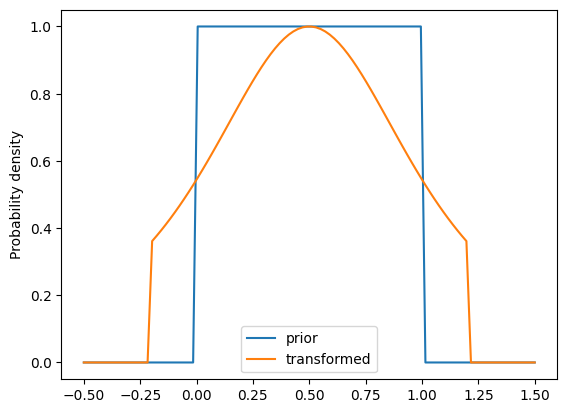

In [ ]:
import matplotlib.pyplot as plt

xs = jnp.linspace(-0.5, 1.5, 100)
ld = sampler.prior.log_density(xs)
plt.plot(xs, jnp.exp(ld), label='prior')

ld = sampler.log_density(xs)
plt.plot(xs, jnp.exp(ld), label='transformed')

plt.ylabel('Probability density')

plt.legend()
plt.show()

## Autodiff Jacobian

Especially in higher-dimensional cases, it is important to design the vector field architecture such that efficient divergence computation can be implemented, if this is used to compute the log-density change.
However, in lower-dimension and for prototyping, it may be sufficient to use JAX's automatic differentiation to compute the Jacobian.
For convenience this is implemented in {class}`AutoJacVF`.
It wraps a vector field (callable) that only returns $dx/dt$ and converts it into a new vector field that also returns the negative divergence (trace of the Jacobian).


In [ ]:
def two_dim_vf(t, x):
    # some two dimensional vector field
    return jnp.sin(x) + jnp.cos(x[..., ::-1])

# event_dim=1 indicates x is a vector (one event dimension)
vf = bijx.AutoJacVF(two_dim_vf, event_dim=1)

# now returns both dx/dt and -tr(jac)
# this vf can be used to define a continuous flow as above
vf(0, jnp.array([1.0, 2.0]))

(Array([0.4253241, 1.4495997], dtype=float32),
 Array(-0.12415543, dtype=float32))